## Demo notebook for accessing HLS data on Azure

This notebook provides an example of accessing HLS (Harmonized Landsat Sentinel-2) data from blob storage on Azure, extracting image metadata using [GDAL](https://gdal.org), and displaying an image using GDAL and [rasterio](https://github.com/mapbox/rasterio).

HLS data are stored in the East US 2 region, so this notebook will run more efficiently on the Azure compute located in East US 2.  You don't want to download hundreds of terabytes to your laptop! If you are using HLS data for environmental science applications, consider applying for an [AI for Earth grant](http://aka.ms/ai4egrants) to support your compute requirements.

HLS data on Azure are managed by [Ag-Analytics](https://analytics.ag). Ag-Analytics also provides an [API](https://ag-analytics.portal.azure-api.net/docs/services/harmonized-landsat-sentinel-service/operations/hls-service) which allows the caller to query to perform spatial queries over the HLS archive, as well as querying for additional data such as cloud cover and Normalized Difference Vegetation Index (NDVI).  Ag-Analytics also provides an [API](https://aganalyticsapimanagementservice.portal.azure-api.net/docs/services/hls-service/operations/post-detect-tiles?) to retrieve tile IDs matching spatial queries.

### Imports and environment

In [2]:
# Standard-ish packages
import requests
import re
import numpy as np
import urllib
import io
import matplotlib.pyplot as plt
import pandas as pd

# Less standard, but all of the following are pip- or conda-installable
import rasterio

# pip install azure-storage-blob
from azure.storage.blob import ContainerClient

from osgeo import gdal,osr

# Storage locations are documented at http://aka.ms/ai4edata-hls
hls_container_name = 'hls'
hls_account_name = 'hlssa'
hls_account_url = 'https://' + hls_account_name + '.blob.core.windows.net/'
hls_blob_root = hls_account_url + hls_container_name

# This file is provided by NASA; it indicates the lat/lon extents of each
# hls tile.
#
# The file originally comes from:
#
# https://hls.gsfc.nasa.gov/wp-content/uploads/2016/10/S2_TilingSystem2-1.txt
#
# ...but as of 8/2019, there is a bug with the column names in the original file, so we
# access a copy with corrected column names.
hls_tile_extents_url = 'https://ai4edatasetspublicassets.blob.core.windows.net/assets/S2_TilingSystem2-1.txt'

# Load this file into a table, where each row is:
#
# Tile ID, Xstart, Ystart, UZ, EPSG, MinLon, MaxLon, MinLon, MaxLon
print('Reading tile extents...')
s = requests.get(hls_tile_extents_url).content
hls_tile_extents = pd.read_csv(io.StringIO(s.decode('utf-8')),delimiter=r'\s+')
print('Read tile extents for {} tiles'.format(len(hls_tile_extents)))

hls_container_client = ContainerClient(account_url=hls_account_url, 
                                         container_name=hls_container_name,
                                         credential=None)

Reading tile extents...
Read tile extents for 56686 tiles


### Functions

In [3]:
def get_hls_tile(blob_url):
    """
    Given a URL pointing to an HLS image in blob storage, load that image via GDAL
    and return both data and metadata.
    """    
    
    formatted_gdal_bloburl='/{}/{}'.format('vsicurl',blob_url)
    
    tile_open = gdal.Open(formatted_gdal_bloburl)
    data = tile_open.GetRasterBand(1)
    ndv,xsize,ysize = data.GetNoDataValue(),tile_open.RasterXSize,tile_open.RasterYSize
    
    projection = osr.SpatialReference()
    projection.ImportFromWkt(tile_open.GetProjectionRef())
    
    datatype = data.DataType
    datatype = gdal.GetDataTypeName(datatype)  
    data_array = data.ReadAsArray()

    return ndv,xsize,ysize,projection,data_array


def list_available_tiles(prefix):
    """
    List all blobs in an Azure blob container matching a prefix.  
    
    We'll use this to query tiles by location and year.
    """
    
    files = []
    generator = hls_container_client.list_blobs(name_starts_with=prefix)
    for blob in generator:
        files.append(blob.name)
    return files

    
def lat_lon_to_hls_tile_id(lat,lon):
    """
    Get the hls tile ID for a given lat/lon coordinate pair.
    """  
    
    found_matching_tile = False

    for i_row,row in hls_tile_extents.iterrows():
        found_matching_tile = lat >= row.MinLat and lat <= row.MaxLat \
        and lon >= row.MinLon and lon <= row.MaxLon
        if found_matching_tile:
            break
    
    if not found_matching_tile:
        return None
    else:
        return row.TilID

### Find a tile for a given location and date

In [4]:
# Specify a location and year of interest
lat = 47.6101; lon = -122.2015 # Bellevue, WA

year = '2019'
daynum = '109'    # 1-indexed day-of-year
folder = 'S309'   # 'S309' for Sentinel, 'L309' for Landsat
product = 'S30'   # 'S30' for Sentinel, 'L30' for Landsat
year = '2019'

tile_id = lat_lon_to_hls_tile_id(lat,lon)
assert tile_id is not None, 'Invalid lat/lon'
prefix = folder + '/HLS.' + product + '.T' + tile_id + '.' + year

print('Finding tiles with prefix {}'.format(prefix))
matches = list_available_tiles(prefix)
assert len(matches) > 0, 'No matching tiles'

blob_name = matches[0]
print('Found {} matching tiles, using file {}'.format(len(matches),blob_name))

Finding tiles with prefix S309/HLS.S30.T10TET.2019
Found 1918 matching tiles, using file S309/HLS.S30.T10TET.2019001.v1.4_01.tif


### ...or build a tile path from components

In [5]:
lat = 47.6101; lon = -122.2015 # Bellevue, WA

year    = '2019'
daynum  = '001'   # 1-indexed day-of-year
folder  = 'S30'   # 'S30' for Sentinel, 'L30' for Landsat
product = 'S30'   # 'S30' for Sentinel, 'L30' for Landsat
band    = '01'
tile_id = '10TET' # See hls.gsfc.nasa.gov/wp-content/uploads/2016/10/S2_TilingSystem2-1.txt
version = 'v1.4'  # Currently always v1.4

blob_name = folder + '/HLS.' + product + '.T' + tile_id + '.' + year + daynum + '.' + version \
    + '_' + band + '.tif'

print('Using file {}'.format(blob_name))

Using file S30/HLS.S30.T10TET.2019001.v1.4_01.tif


###  Access one band of the selected image using GDAL's virtual file system ([vsicurl](https://gdal.org/user/virtual_file_systems.html#vsicurl-http-https-ftp-files-random-access))

    

In [6]:
gdal.SetConfigOption('GDAL_HTTP_UNSAFESSL', 'YES')
blob_url = hls_blob_root + '/' + blob_name
print('Reading tile from {}'.format(blob_url))
ndv,xsize,ysize,projection,data_array = get_hls_tile(blob_url)

print('No-data value: {}'.format(ndv))
print('\nSize: {},{}'.format(xsize,ysize))
print('\nProjection:\n{}'.format(projection))

Reading tile from https://hlssa.blob.core.windows.net/hls/S30/HLS.S30.T10TET.2019001.v1.4_01.tif
No-data value: -1000.0

Size: 3660,3660

Projection:
PROJCS["UTM Zone 10, Northern Hemisphere",
    GEOGCS["Unknown datum based upon the WGS 84 ellipsoid",
        DATUM["Not_specified_based_on_WGS_84_spheroid",
            SPHEROID["WGS 84",6378137,298.257223563,
                AUTHORITY["EPSG","7030"]]],
        PRIMEM["Greenwich",0],
        UNIT["degree",0.0174532925199433]],
    PROJECTION["Transverse_Mercator"],
    PARAMETER["latitude_of_origin",0],
    PARAMETER["central_meridian",-123],
    PARAMETER["scale_factor",0.9996],
    PARAMETER["false_easting",500000],
    PARAMETER["false_northing",0],
    UNIT["metre",1,
        AUTHORITY["EPSG","9001"]]]


### Display a Sentinel-2 image using rasterio and vsicurl



Reading bands from:
/vsicurl/https://hlssa.blob.core.windows.net/hls/S30/HLS.S30.T10TET.2019001.v1.4_02.tif
/vsicurl/https://hlssa.blob.core.windows.net/hls/S30/HLS.S30.T10TET.2019001.v1.4_03.tif
/vsicurl/https://hlssa.blob.core.windows.net/hls/S30/HLS.S30.T10TET.2019001.v1.4_04.tif


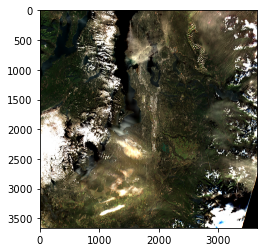

In [7]:
# Bands 2, 3, and 4 are B, G, and R in Sentinel-2 HLS images

base_url = '/vsicurl/' + hls_blob_root + '/' + blob_name
band2_url = re.sub('_(\d+).tif','_02.tif',base_url)
band3_url = re.sub('_(\d+).tif','_03.tif',base_url)
band4_url = re.sub('_(\d+).tif','_04.tif',base_url)
print('Reading bands from:\n{}\n{}\n{}'.format(band2_url,band3_url,band4_url))

band2 = rasterio.open(band2_url)
band3 = rasterio.open(band3_url)
band4 = rasterio.open(band4_url)

norm_value = 2000
image_data = []
for band in [band4,band3,band2]:
    band_array = band.read(1)
    band_array = band_array / norm_value
    image_data.append(band_array)
    band.close()

rgb = np.dstack((image_data[0],image_data[1],image_data[2]))
np.clip(rgb,0,1,rgb)
plt.imshow(rgb)

### Read the jpeg thumbnail from a COG file without reading the whole file

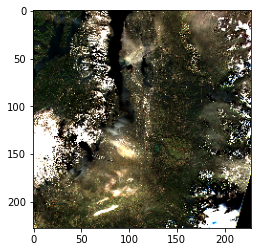

In [8]:
rgb_urls = [band4_url, band3_url, band2_url]

thumbnail_data = []

# url = rgb_urls[0]
for url in rgb_urls:
    
    # From:
    #
    # https://automating-gis-processes.github.io/CSC/notebooks/L5/read-cogs.html
    with rasterio.open(url) as raster:
        
        # List of overviews from largest to smallest
        oviews = raster.overviews(1)
    
        # Retrieve the second-largest thumbnail
        decimation_level = oviews[1]
        h = int(raster.height/decimation_level)
        w = int(raster.width/decimation_level)
        
        thumbnail_channel = raster.read(1, out_shape=(1, h, w)) / norm_value
        thumbnail_data.append(thumbnail_channel)

rgb = np.dstack((thumbnail_data[0],thumbnail_data[1],thumbnail_data[2]))
np.clip(rgb,0,1,rgb)
plt.imshow(rgb)